In [2]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [3]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [4]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [5]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    N = y.shape[0]
    e = y - tx @ w
    return 1/(2*N) * np.sum(np.square(e))


In [6]:
MSE = compute_loss(y, tx, np.array([1,2]))
print("MSE: %f" %MSE)

MSE: 2694.483366


In [7]:
a = np.array([1,2,4])
b = np.array([1,2,3])
print(a*b)

[ 1  4 12]


# 2. Grid Search

Fill in the function `grid_search()` below:

In [8]:
def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """
    num_grid_pts_w0 = grid_w0.shape[0]
    num_grid_pts_w1 = grid_w1.shape[0]

    losses = np.empty(shape = (num_grid_pts_w0, num_grid_pts_w1))
    for i,w0 in enumerate(grid_w0):
        for j,w1 in enumerate(grid_w1):
            losses[i,j] = compute_loss(y, tx, np.array([w0, w1]))
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=42.42448314678248, w0*=66.66666666666669, w1*=16.666666666666686, execution time=0.015 seconds


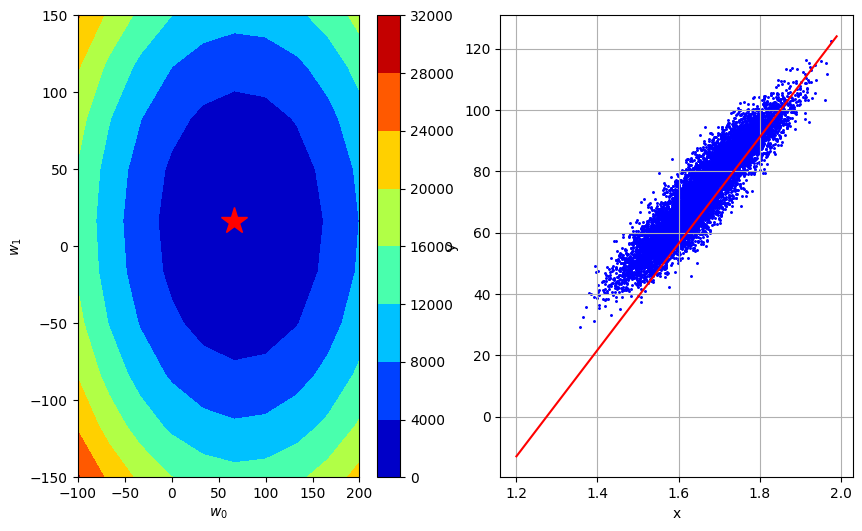

In [9]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [10]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    N = y.shape[0]
    e = y - tx @ w
    return -1/N * (np.transpose(tx) @ e)

In [11]:
print("Gradient for [100, 20]: " + str(compute_gradient(y,tx,np.array([100, 20]))))
print("Gradient for [50, 10]: " + str(compute_gradient(y,tx,np.array([50, 10]))))

Gradient for [100, 20]: [26.706078    6.52028757]
Gradient for [50, 10]: [-23.293922    -3.47971243]


Please fill in the functions `gradient_descent` below:

In [12]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):

        loss = compute_loss(y,tx,w)
        grad = compute_gradient(y,tx,w)
        w = ws[n_iter] - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [13]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.30574540147368, w1=9.435798704492349
GD iter. 1/49: loss=265.3024621089587, w0=66.69746902191575, w1=12.26653831584002
GD iter. 2/49: loss=37.87837955044097, w0=71.31498610804836, w1=13.115760199244335
GD iter. 3/49: loss=17.41021212017444, w0=72.70024123388815, w1=13.370526764265632
GD iter. 4/49: loss=15.56807705145045, w0=73.11581777164008, w1=13.446956733772025
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.386020684743531, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638307, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=15.385887965652202, w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543452, w0=73.29388305071, w1=13.479705271317192
GD

In [14]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [15]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    N = y.shape[0]
    e = y - tx @ w
    return -1/N * (np.transpose(tx) @ e)
    
def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            #print(minibatch_y)
            #print(minibatch_tx)
            loss = compute_loss(minibatch_y, minibatch_tx, w)
            grad = compute_stoch_gradient(minibatch_y,minibatch_tx,w)
            w = ws[n_iter] - gamma * grad

            # store w and loss
            ws.append(w)
            losses.append(loss)
            
            print(
                "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
                )
            )
    return losses, ws

In [16]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=3244.148054574601, w0=8.054996032990458, w1=2.396491517069974
SGD iter. 1/49: loss=3334.806764100482, w0=16.221766219668275, w1=11.150141615526083
SGD iter. 2/49: loss=1806.6307103015286, w0=22.232807244817792, w1=21.410684819447695
SGD iter. 3/49: loss=1313.9789952520653, w0=27.359168518181317, w1=19.246906075100245
SGD iter. 4/49: loss=890.984211587393, w0=31.58050530073585, w1=25.26956974985924
SGD iter. 5/49: loss=832.5636527112143, w0=35.66110244505484, w1=29.550738461637888
SGD iter. 6/49: loss=1290.3893070226752, w0=40.741238874369856, w1=25.62947472101956
SGD iter. 7/49: loss=239.40883862244138, w0=42.929429170584704, w1=28.14720550273762
SGD iter. 8/49: loss=15.62059024594032, w0=43.48836727531438, w1=28.779052714731712
SGD iter. 9/49: loss=528.9433242816565, w0=46.7408842215628, w1=26.63047793359786
SGD iter. 10/49: loss=805.4592573337202, w0=50.754509160028576, w1=20.88481855943375
SGD iter. 11/49: loss=423.62728532912473, w0=53.665272926908756, w1=19.73

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

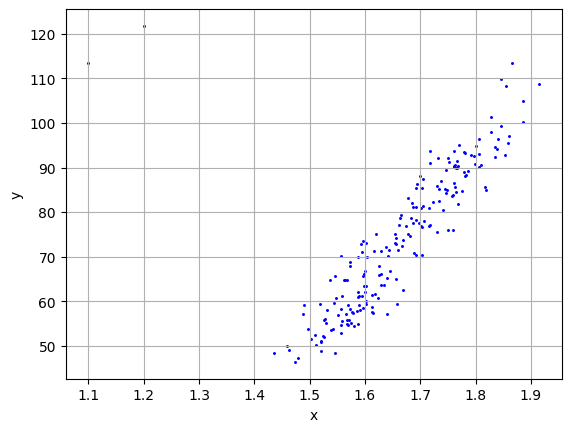

In [18]:
import datetime
from helpers import *
from plots import *


# ***************************************************
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(height, weight, marker=".", color="b", s=5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()
plt.show()

In [19]:
y.shape, tx.shape

((202,), (202, 2))

In [20]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)

end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.847464098448484, w1=7.724426406192441
GD iter. 1/49: loss=318.282124701595, w0=67.401703327983, w1=10.041754328050121
GD iter. 2/49: loss=88.6423556165126, w0=72.06797509684336, w1=10.736952704607413
GD iter. 3/49: loss=67.97477639885521, w0=73.46785662750146, w1=10.945512217574594
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.05160722578589, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225756, w1=11.034889001593537
GD iter

In [21]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [22]:
from costs import compute_loss_MAE
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    N = y.shape[0]
    e = y - tx @ w
    return -1/N * np.transpose(tx) @ np.sign(e)

In [23]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        loss = compute_loss_MAE(y,tx,w)
        grad = compute_subgradient_mae(y,tx,w)
        w = ws[n_iter] - gamma * grad

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [24]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7000000000000004, w1=7.625844400394043e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4000000000000008, w1=1.5251688800788087e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.1000000000000014, w1=2.287753320118213e-15
SubGD iter. 3/499: loss=71.96780585492637, w0=2.8000000000000016, w1=3.0503377601576174e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5000000000000018, w1=3.812922200197022e-15
SubGD iter. 5/499: loss=70.56780585492639, w0=4.200000000000002, w1=4.575506640236426e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.900000000000002, w1=5.3380910802758305e-15
SubGD iter. 7/499: loss=69.16780585492637, w0=5.600000000000002, w1=6.100675520315235e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.3000000000000025, w1=6.863259960354639e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000003, w1=7.625844400394044e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000003, w1=8.388428840433449e-15


In [25]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [28]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            #print(minibatch_y)
            #print(minibatch_tx)
            loss = compute_loss_MAE(minibatch_y, minibatch_tx, w)
            grad = compute_subgradient_mae(minibatch_y,minibatch_tx,w)
            w = ws[n_iter] - gamma * grad

            # store w and loss
            ws.append(w)
            losses.append(loss)
            
            print(
                "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                    bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
                )
            )
    return losses, ws

In [29]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/499: loss=84.79016933044119, w0=0.7, w1=0.7009339974347526
SGD iter. 1/499: loss=92.28777346253807, w0=1.4, w1=1.7848093941260545
SGD iter. 2/499: loss=75.56457861293175, w0=2.0999999999999996, w1=1.8001170608381905
SGD iter. 3/499: loss=83.7609282166469, w0=2.8, w1=2.2666991868047655
SGD iter. 4/499: loss=64.1841515964924, w0=3.5, w1=2.1858848813160545
SGD iter. 5/499: loss=52.50173753468976, w0=4.2, w1=1.482379962925192
SGD iter. 6/499: loss=57.960996289724854, w0=4.9, w1=1.238353138216041
SGD iter. 7/499: loss=51.80543563062303, w0=5.6000000000000005, w1=0.6255549672146288
SGD iter. 8/499: loss=47.054228865842745, w0=6.300000000000001, w1=-0.18255877382730412
SGD iter. 9/499: loss=106.25641338555462, w0=7.000000000000001, w1=-3.5557024514169813
SGD iter. 10/499: loss=64.44144283747477, w0=7.700000000000001, w1=-3.549274570538635
SGD iter. 11/499: loss=71.11747713243321, w0=8.4, w1=-3.194247093008809
SGD iter. 12/499: loss=94.1519068178507, w0=9.1, w1=-2.181808755142388
S

In [30]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>